<a href="https://colab.research.google.com/github/Cori-J/Estadistica/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f
# Importacion de modulos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import os
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Data link
# https://www.ine.gob.bo/index.php/nacional/

# Data
path = os.getcwd()
doc =  '/Emp - 2021_05_1_Nal - Serie_Historica.xlsx'
sheet = 'CUADRO Nº 1.4 VAR 12 MESES'
data = pd.read_excel( path + doc, sheet_name =  sheet, header = 4) # import data

# Clean data 

data = data.drop([0, 13, 14], axis = 0) # drop rows
data = data.drop([1937, 'MES'], axis = 1) # drop columns
filas = data.shape[0] * data.shape[1] 
filas = data.shape[0] * data.shape[1] 
data = np.array(data) # convertion to array
data = pd.DataFrame( data.reshape(filas, 1, order = 'F')) # create DF
data.index = pd.period_range('1/1/1938', periods = filas , freq = 'M') # Create Index
data = data.rename(columns = {0:'inflacion'}) # Rename column
data = data.dropna() #remove NaN
data['diff_inf'] = data.diff(axis = 0) #.fillna(0) # Create new column
test = data['2021-01':]
data = data['2013-01': '2020-12']

data['month'] = data.index.month
data['year'] = data.index.year

data.tail()

,inflacion,diff_inf,month,year
2020-08,1.388457,0.042321,8,2020
2020-09,0.456651,-0.931806,9,2020
2020-10,0.275705,-0.180946,10,2020
2020-11,-1.096150,-1.371855,11,2020
2020-12,0.670472,1.766622,12,2020


In [ ]:
# Data describe
data.describe()
#data.info()

,inflacion,diff_inf,month,year
count,96.000000,96.000000,96.000000,96.000000
mean,3.387024,-0.040309,6.500000,2016.500000
std,1.855528,0.622093,3.470174,2.303316
min,-1.096150,-1.943286,1.000000,2013.000000
25%,1.794512,-0.451960,3.750000,2014.750000
50%,3.225957,0.037115,6.500000,2016.500000
75%,4.727764,0.280233,9.250000,2018.250000
max,7.501403,1.766622,12.000000,2020.000000


<AxesSubplot:title={'center':'Serie completa'}>

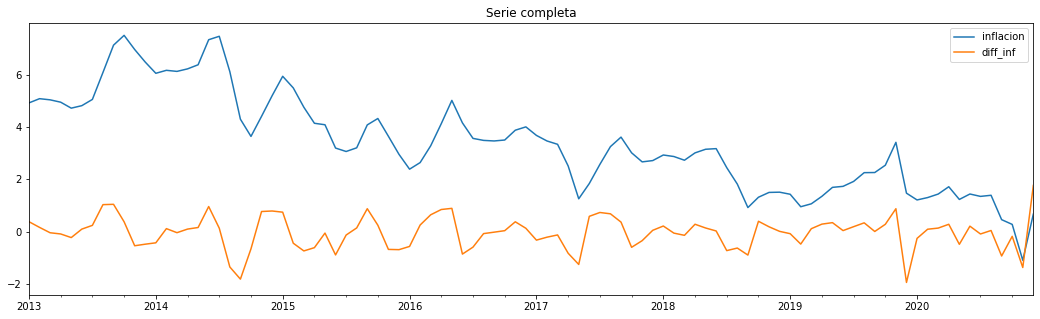

In [ ]:
# Data Graph
data[['inflacion', 'diff_inf']].plot(figsize = (18,5), title = 'Serie completa') # Graph Complate

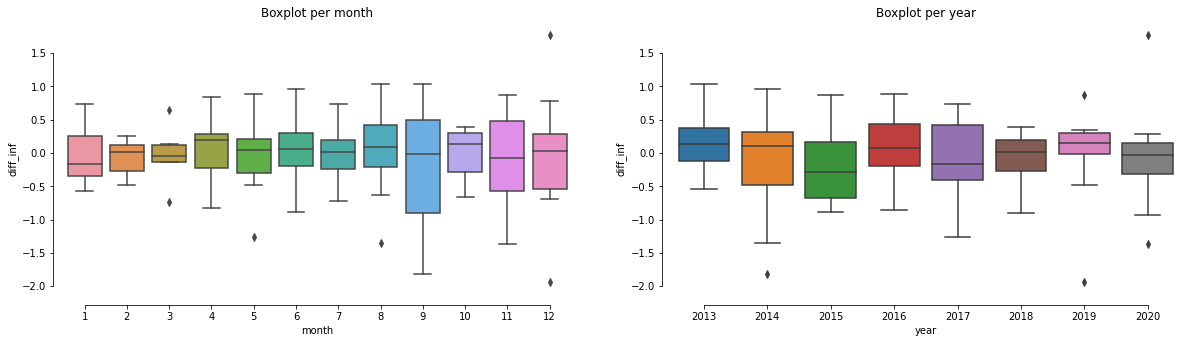

In [ ]:
# boxplot for month and year
fig, ax = plt.subplots (ncols = 2, nrows = 1, figsize = (20,5))
sns.boxplot(x = 'month', y = 'diff_inf', data = data, ax = ax[0]).set_title('Boxplot per month')
sns.boxplot(x = 'year', y = 'diff_inf', data = data, ax = ax[1]).set_title('Boxplot per year')
sns.despine(offset=10, trim=True)

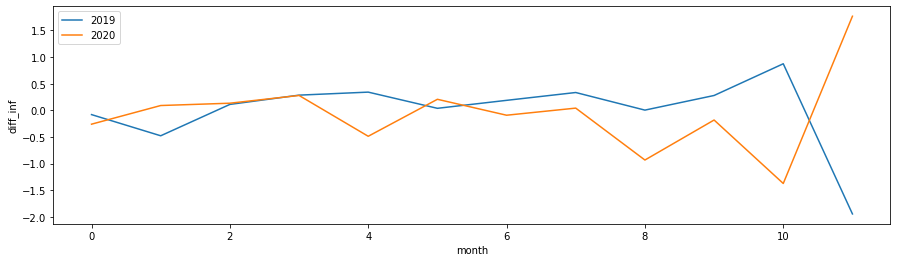

In [ ]:
fig = plt.figure(figsize = (15, 4))
plt.plot(data['diff_inf']['2019-01':'2019-12'].values, label = '2019')
plt.plot(data['diff_inf']['2020-01':'2020-12'].values, label = '2020')
plt.ylabel('diff_inf')
plt.xlabel('month')
plt.legend()

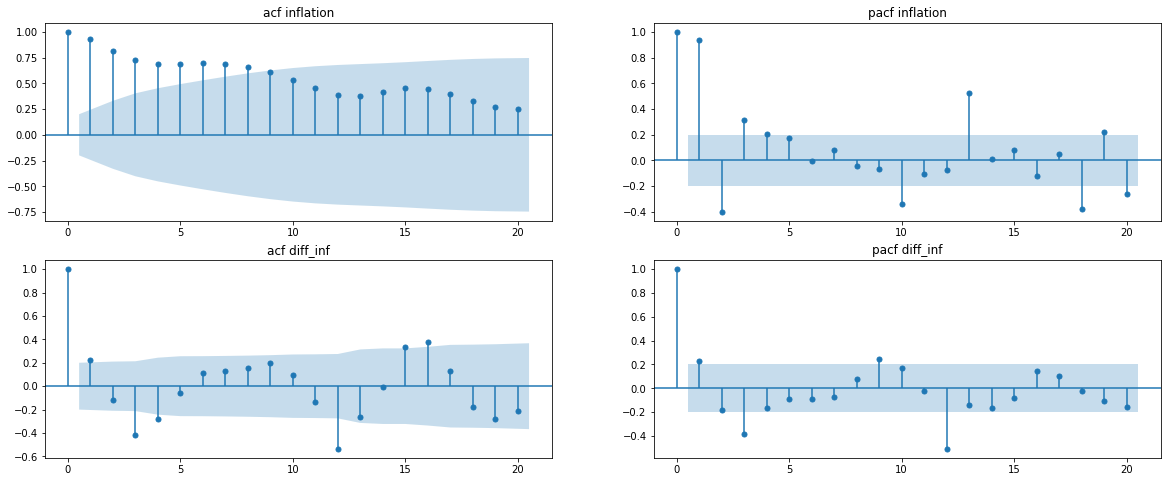

In [ ]:
## Graph ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots (ncols = 2, nrows = 2, figsize = (20,8))
plot_acf(data['inflacion'], title = 'acf inflation', ax = ax[0, 0])
plot_acf(data['diff_inf'], title = 'acf diff_inf', ax = ax[1, 0])
plot_pacf(data['inflacion'], title = 'pacf inflation', ax = ax[0, 1])
plot_pacf(data['diff_inf'], title = 'pacf diff_inf', ax = ax[1,1]);

In [ ]:
# searches the value of p and q with minimum information criteria
def Arma(p, q, y, x = None):
    g = []
    for i in range(p):
        for j in range(q):
            md = ARIMA(endog = y, exog = x, order = (i, 0, j)).fit(method = 'innovations_mle')
            l = [f'{i} - {j}', md.aic, md.bic, md.hqic]
            g.append(l) 
    df = pd.DataFrame(data = np.array(g)[:,1:], index = np.array(g)[:, 0], columns = ['AIC', 'BIC', 'HIC'], dtype = float).round(2)
    return df

In [ ]:
# Create endogenous variable
y = data.diff_inf
df_a = Arma(2, 2, y)

In [ ]:
# Min information criteria 
print(df_a[['AIC', 'BIC', 'HIC']].idxmin())
print('-------------')
print(df_a.min())

AIC    0 - 1
BIC    0 - 1
HIC    0 - 1
dtype: object
-------------
AIC    179.58
BIC    187.28
HIC    182.69
dtype: float64


<AxesSubplot:>

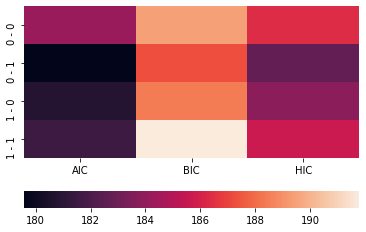

In [ ]:
from seaborn import heatmap
ax = heatmap(df_a, cbar_kws={"orientation": "horizontal"})
ax

<AxesSubplot:title={'center':'Residuals'}>

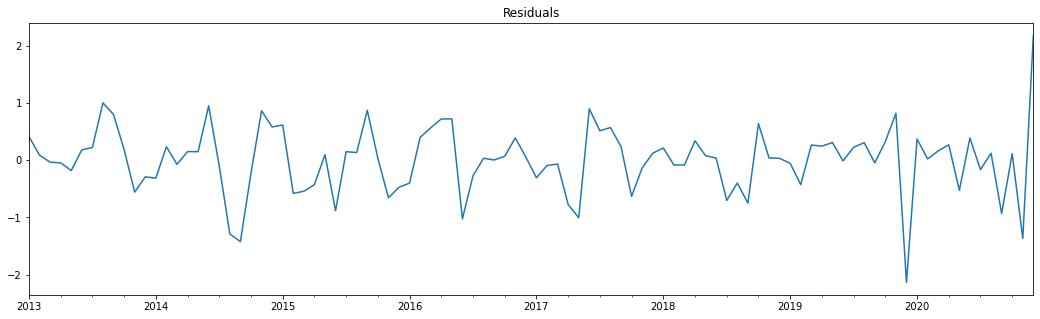

In [ ]:
model_a = ARIMA(y, order = (0, 0, 1)).fit(method='innovations_mle')
model_a.resid.plot(figsize = (18, 5), title = 'Residuals')

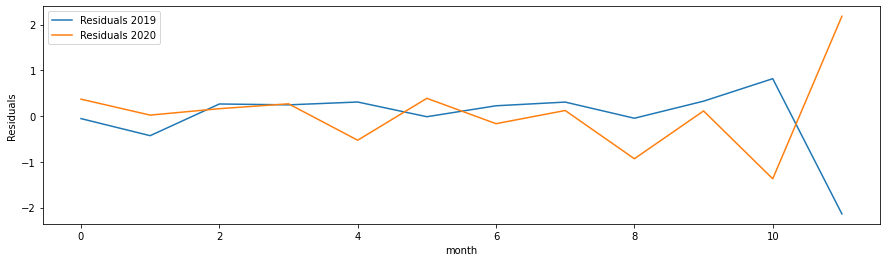

In [ ]:
fig = plt.figure(figsize = (15, 4))
plt.plot(model_a.resid['2019-01':'2019-12'].values, label = 'Residuals 2019')
plt.plot(model_a.resid['2020-01':'2020-12'].values, label = 'Residuals 2020')
plt.ylabel('Residuals')
plt.xlabel('month')
plt.legend()

In [ ]:
# data max and min
print(data['diff_inf'].idxmin())
print(data['diff_inf'].idxmax())

2019-12
2020-12


In [ ]:
# Create dummys

# to capture outliers 

d19_09 = [0] * len(y)
d19_12 = [0] * len(y) 
d20_12 = [0] * len(y)

d19_09[len(y[:'2019-09']) - 1 ] = 1
d19_12[len(y[:'2019-12']) - 1] = 1
d20_12[len(y[:'2020-12']) - 1] = 1

dic = {'d19_09' : d19_09, 'd19_12' : d19_12, 'd20_12' : d20_12}

x = pd.DataFrame(dic)
x.index = y.index   

In [ ]:
 # Search the model with low information criteria 
df_b = Arma(3, 3, y, x) 

# Min information criteria
print(df_b[['AIC', 'BIC', 'HIC']].idxmin())

print("-------------")
# Comparation between df_a and df_b
print(df_b.min() < df_a.min())


AIC    2 - 1
BIC    2 - 1
HIC    2 - 1
dtype: object
-------------
AIC    True
BIC    True
HIC    True
dtype: bool


<AxesSubplot:>

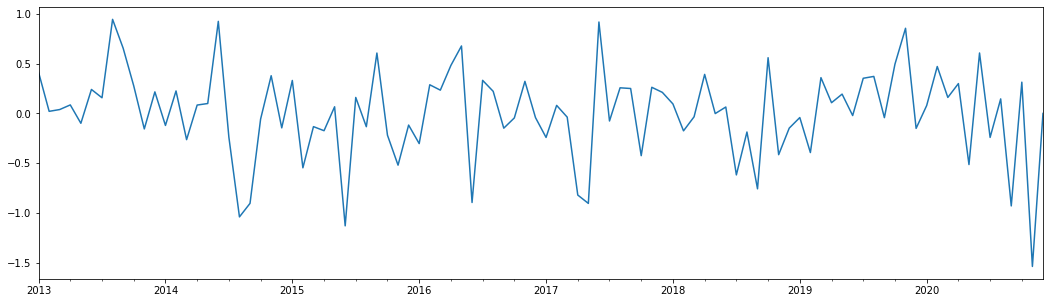

In [ ]:
model_b = ARIMA(y, x, order = (2, 0, 1)).fit(method = 'innovations_mle')
model_b.resid.plot(figsize = (18, 5))

In [ ]:
# Model a
print(model_a.summary())

                               SARIMAX Results                                
Dep. Variable:               diff_inf   No. Observations:                   96
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -86.791
Date:                Tue, 22 Jun 2021   AIC                            179.583
Time:                        11:47:27   BIC                            187.276
Sample:                    01-31-2013   HQIC                           182.692
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0329      0.083     -0.395      0.693      -0.196       0.130
ma.L1          0.2788      0.097      2.860      0.004       0.088       0.470
sigma2         0.3568      0.044      8.198      0.0

In [ ]:
# Model b
print(model_b.summary())

                               SARIMAX Results                                
Dep. Variable:               diff_inf   No. Observations:                   96
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -60.969
Date:                Tue, 22 Jun 2021   AIC                            137.938
Time:                        11:47:27   BIC                            158.453
Sample:                    01-31-2013   HQIC                           146.231
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0343      0.044     -0.786      0.432      -0.120       0.051
d19_09         0.0320      0.589      0.054      0.957      -1.123       1.187
d19_12        -2.0460      0.980     -2.088      0.0

In [ ]:
# Autoarima with x13 census

from statsmodels.tsa.x13 import x13_arima_analysis
path_n = '/home/cori/Documentos/Python/x13as/x13as-v1-1-b39/x13as'
x13results = x13_arima_analysis(endog = y, x12path= path_n, outlier=True, print_stdout= False, retspec=True)
print(x13results.results.split('\x0c')[3])

        diff_inf            PAGE   3, SERIES diff_inf
                        Automatic ARIMA Model Selection

                    Procedure based closely on TRAMO method 
                         of Gomez and Maravall (2000)
              "Automatic Modeling Methods for Univariate Series",
                            A Course in Time Series
                  (Edited by D. Pena, G. C. Tiao, R. S. Tsay),
                         New York : J. Wiley and Sons


     Maximum order for regular ARMA parameters :   2
     Maximum order for seasonal ARMA parameters :   1
     Maximum order for regular differencing :   2
     Maximum order for seasonal differencing :   1

   Results of Unit Root Test for identifying orders of differencing:
     Regular difference order :   0
     Seasonal difference order :   0

  Automatic model choice : (0 0 0)(0 0 1)


  Final Checks for Identified Model


  Checking for Unit Roots.
   No unit roots found.

  Checking for insignificant ARMA coefficients.

  

                                    SARIMAX Results                                     
Dep. Variable:                         diff_inf   No. Observations:                   96
Model:             ARIMA(3, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 -40.558
Date:                          Tue, 22 Jun 2021   AIC                            101.117
Time:                                  11:47:36   BIC                            126.760
Sample:                              01-31-2013   HQIC                           111.482
                                   - 12-31-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0327      0.013     -2.547      0.011      -0.058      -0.008
d19_09        -0.0575      0.259     -0.222      0.

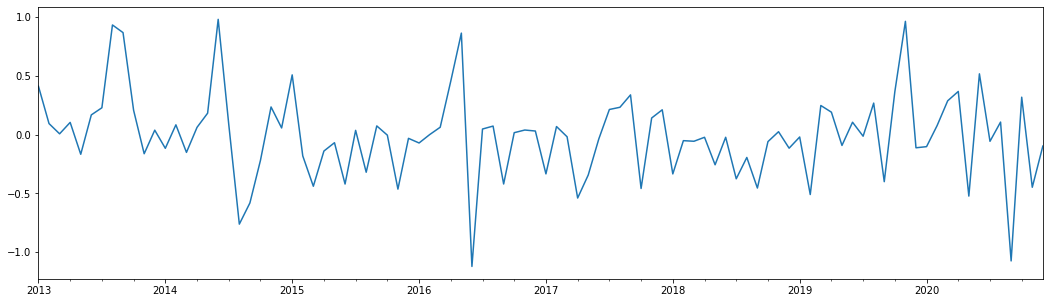

In [ ]:
# Model Census-x13
model_x13 = ARIMA (y, x, order = (3, 0, 1), seasonal_order = (0, 0, 1, 12)).fit(method = 'innovations_mle')
model_x13.resid.plot(figsize = (18, 5))
print(model_x13.summary())

<AxesSubplot:>

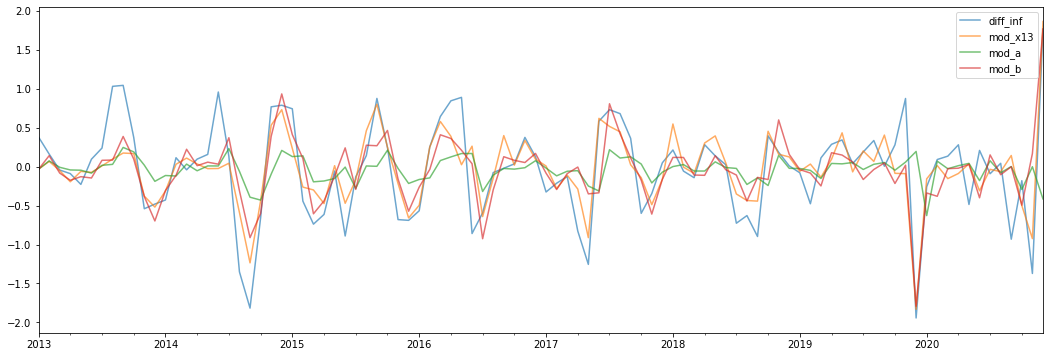

In [ ]:
data['mod_x13'] = model_x13.predict()
data['mod_a'] = model_a.predict() 
data['mod_b'] = model_b.predict()
data.drop(['inflacion', 'month', 'year'], axis = 1).plot(figsize = (18, 6), alpha = 0.65)

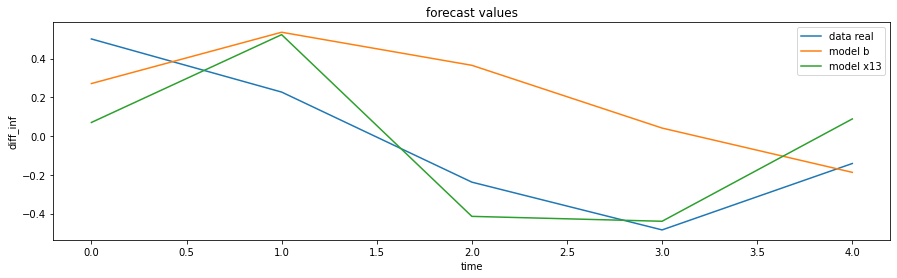

In [ ]:
mod_bf = model_b.forecast(steps = 5, exog = x[:5])
mod_x13f = model_x13.forecast(steps = 5, exog = x[:5])

fig = plt.figure(figsize = (15, 4))
plt.title('forecast values')
plt.plot(test['diff_inf'].values, label = 'data real')
plt.plot(mod_bf.values, label = 'model b')
plt.plot(mod_x13f.values, label = 'model x13')
plt.ylabel('diff_inf')
plt.xlabel('time')
plt.legend()

In [ ]:
# the model_x13 is the one that best predicts the out-of-sample data,
# this may be due to the fact that it incorporates a seasonal
#  moving average while the model_b does not.